# Control Systems 1, NB07: Time-Domain specifications and PID

© 2024 ETH Zurich, Mark Benazet Castells, Jonas Holinger, Felix Muller, Matteo Penlington; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

This interactive notebook is designed to introduce fundamental concepts in control systems engineering. It covers the steady-state error, different Time-Domain Specifications for first and second order systems. It also features how to approximate higher order system using Dominant pole approximation. Furthermore, it introduces the PID-controller.

Authors:
- Jonas Holinger; jholinger@ethz.ch
- Shubham Gupta; shugupta@ethz.ch

# Learning Objectives


After completing this notebook, you should be able to:

1. Determine the steady-state error of a system.
2. Understand different time-domain specifications for first and second order system.
3. Understand how to design the system such that the specifications are met.
4. Understand how to approximate higher order systems using dominant pole approximation
5. Have a basic understanding of PID-Controllers.

In [ ]:
%pip install numpy matplotlib scipy ipywidgets control IPython sympy

In [ ]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from scipy.integrate import odeint
from IPython.display import display, clear_output, Math
from ipywidgets import interactive, FloatSlider, VBox, ToggleButton, FloatSlider
from scipy import signal


# Steady State Error


The steady-state error is the difference between the system reference signal $r(t)$ and the closed-loop output $y(t)$ as $ \displaystyle \lim_{t \to \infty}$.

Applying the final value theorem, we know that we can calculate the steady-state error with:
<br><br>
$$ e_{ss}=  \displaystyle \lim_{t \to \infty } e(t) =  \displaystyle \lim_{s \to 0} s \cdot E(s) $$
### Example
We have an open-loop transfer function $C(s)P(s)$ with an integrator, and there is a pole at $s=0$. Let’s define the open-loop transfer function $C(s)P(s)$ as
$$ L(s) = \frac{K_{Bode}}{s(s+2)} $$<br>
where $K$ is our system's Bode gain, the $s$ term represents the system's integrator (making our system a **Type 1** system), and $(s+2)$ is an additional stable pole.

The input to the system is a first-order ramp ($q=1$) $r(t) = t$. This input corresponds in the frequency domain to:
$$ R(s) = \frac{1}{s^2} $$

To calculate the error signal $E(s)$, we use the sensitivity function, which is known from previous lectures. The sensitivity function maps the reference input $r$ to the error $e$:
$$ S(s) = \frac{1}{1+P(s)C(s)} = \frac{1}{1+L(s)} $$

We can multiply the sensitivity function $S$ with our input $R(s)$ and apply the final value theorem to get our steady-state error:
$$ e_{ss} = \displaystyle \lim_{s \to 0} s \cdot E(s) = \displaystyle \lim_{s \to 0} s \cdot R(s) \cdot \frac{1}{1+L(S)} = \displaystyle \lim_{s \to 0} s \cdot \frac{\frac{1}{s^2}}{1+\frac{K}{s(s+2)}} $$

The steady-state error we get after applying the limit is
$$ e_{ss} = \frac{2}{K} $$
which corresponds to the inverse of our Bode gain $K_{Bode}$. If the system is stable and $q=0$, the Bode gain corresponds to the steady-state gain for a unit step input and is called the DC gain.

If we now add a second integrator to our system, $C(s) = s^2$ making it a **Type 2** system and calculate our steady-state error again:
$$ e_{ss} = \displaystyle \lim_{s \to 0} s \cdot \frac{\frac{1}{s^2}}{1+\frac{K}{s^2(s+2)}} $$
we see that our steady-state error is exactly zero.

### Conclusion
To achieve a steady-state error of zero, you need to have one more integrator than the order of your ramp input. To achieve a small steady-state error, you can increase the Bode gain. To avoid calculating the steady-state error each time, you can use the following table:




| $ e_{ss} $ | $ q = 0 $                   | $ q = 1 $            | $ q = 2 $            |
|-------------|-----------------------------|----------------------|----------------------|
| Type 0      | $ \frac{1}{1 + K_{\text{Bode}}} $ | $ \infty $           | $ \infty $           |
| Type 1      | $ 0 $                        | $ \frac{1}{K_{\text{Bode}}} $ | $ \infty $           |
| Type 2      | $ 0 $                        | $ 0 $                | $ \frac{1}{K_{\text{Bode}}} $ |

### Visualization
Try different combinations of system types and input ramps and observe whether you have a steady-state error or not.


In [ ]:
def simulate_system(system_type, input_type):

    t = np.linspace(0, 125, 1000)

    #P(s) = 1 / (s + 10)
    P = ct.TransferFunction([1], [1, 10])

    if system_type == "Type 0":
        C = ct.TransferFunction([5], [1])
    elif system_type == "Type 1":
        C = ct.TransferFunction([1], [1, 0])
    elif system_type == "Type 2":
        C = ct.TransferFunction([1], [1, 0, 0])



    open_loop_system = C * P
    closed_loop_system = ct.feedback(open_loop_system)

    if input_type == "Unit Ramp" and system_type == "Type 2":
        t = np.linspace(0, 1500, 1000)

    elif input_type == "Unit Parabola" and system_type == "Type 2":
        t = np.linspace(0, 300, 1000)


    if input_type == "Unit Step":
        input_signal = np.ones_like(t)
    elif input_type == "Unit Ramp":
        input_signal = t
    elif input_type == "Unit Parabola":
        input_signal = 0.5 * t**2


    t_out, y_out = ct.forced_response(closed_loop_system, T=t, U=input_signal)

    plt.figure(figsize=(12, 6))
    plt.plot(t, input_signal, 'r--', label='Input Signal', linewidth=2)
    plt.plot(t_out, y_out, 'b-', label='Output Response ', linewidth=2)



    plt.title(f'Input and Output of {system_type} System to {input_type} ')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()



system_type_dropdown = widgets.Dropdown(
    options=["Type 0", "Type 1", "Type 2"],
    value="Type 0",
    description='System Type:',
)

input_type_dropdown = widgets.Dropdown(
    options=["Unit Step", "Unit Ramp", "Unit Parabola"],
    value="Unit Step",
    description='Input Type:',
)



interactive_plot = interactive(simulate_system,
                               system_type=system_type_dropdown,
                               input_type=input_type_dropdown)
display(interactive_plot)


# Time Domain Specifications

## First-Order systems

In both the time domain and the frequency domain, we can analyze a system's response. In the time domain, we typically separate the response into two stages: the transient stage and the steady-state stage. Now we want to examine different behaviors in our time domain.

Let’s consider a stable first-order system: <br>$$G(s)=\frac{K}{τs+1}$$<br>
For an inital condition of $x(0)=0$, the solution is given by: $$y(t)=K-e^{\frac{-t}{\tau}}$$.

We are interested in the following time-domain specifications for a stable first-order system:


**DC gain**
<br>
The Steady-state or DC gain **$y_{ss}$** is a measure of how much the systems output responds to an input after the transients effects have died out.
In our first order system the DC gain corresponds to K.

**Time constant**
<br>
The time constant **$\tau$** measures the speed of the system's response.
 It is defined as the time required for the system's unit step response to reach approximately 63% of its final value.

**Settling time**
<br>
The settling time **$T_d$** is the time it takes for the output to remain within $d\%$ of the final value. The settling time time can be approximated using the time constant $τ$ using the formula $$T_d=τ \cdot log(100/d)$$ For $5\%$ the approximation is $T_d=3\tau$


In [ ]:
def plot_first_order_system(K=3, tau=2):

    sys = ct.TransferFunction([K], [tau, 1])

    t = np.linspace(0, 10 * tau, 1000)

    t, y = ct.step_response(sys, T=t)

    tau_time = tau
    yss = K
    settling_time = -np.log(0.05) * tau

    y_tau = K * (1 - np.exp(-tau_time / tau))
    y_settling = K * (1 - np.exp(-settling_time / tau))

    plt.figure(figsize=(10, 6))

    plt.plot(t, y, label="Step Response", color="blue")

    plt.plot(t, np.ones_like(t), label="Step Input", color="orange", linestyle='--')

    plt.axhline(yss, color="red", linestyle="--")

    plt.plot([tau_time, tau_time], [0, y_tau], color="green", linestyle="--")
    plt.plot([settling_time, settling_time], [0, y_settling], color="purple", linestyle="--")

    plt.text(tau_time, 0, f"τ    ", color="green", ha="center", va="bottom", fontsize=10, fontweight="bold")
    plt.text(settling_time, 0, f"Settling Time    ", color="purple", ha="center", va="bottom", fontsize=10, fontweight="bold")

    plt.text(0, yss, f"DC Gain", color="red", ha="left", va="bottom", fontsize=10, fontweight="bold")

    plt.xlabel("Time (s)")
    plt.ylabel("Response")
    plt.title(f"Step Response of First-Order System: G(s) = {K}/({tau}s + 1)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.ylim(0, 1.2 * yss)
    plt.show()

K_slider = widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, description="K:")
tau_slider = widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, description="τ:")

interactive_plot = interactive(plot_first_order_system, K=K_slider, tau=tau_slider)
display(interactive_plot)


## Second-Order system

For a second-order system in the form:
$$G(s) = \frac{\omega_n^2}{s^2 + 2 \zeta \omega_n s + \omega_n^2}
\quad \Longleftrightarrow \quad
\begin{cases}
    \dot{x} = \begin{bmatrix} 0 & 1 \\ -\omega_n^2 & -2 \zeta \omega_n \end{bmatrix} x + \begin{bmatrix} 0 \\ \omega_n^2 \end{bmatrix} u \\
    y = x
\end{cases}
$$
We get the solution by imposing our zero initial condition and solving the algebra:

$$y(t) = 1 - \frac{1}{\cos \varphi} e^{\sigma t} \cos(\omega t + \varphi), \quad t \geq 0.$$

with $ϕ=arctan(\frac{σ}{ω})$

$\omega_n$ denotes the natural frequency of our system, sometimes also called the eigenfrequency. The natural frequency is defined as $\omega_n^2=\sigma^2+\omega^2$ and can be calculated from the pole of the system $s=\sigma+j\omega$.

The damping factor $\zeta = \frac{\sigma}{\omega_n}$ can be used to categorize our system into the following cases:

* $ζ<0$, underdamped
* $ζ=0$, critically damped
* $ζ>0$, overdamped

We can see that the location of the pole in our system determines the natural frequency, the damping ratio, and the time-domain specifications.


In [ ]:
def plot_damping_responses(omega_n):
    damping_ratios = {
        "Underdamped (ζ < 1)": 0.5,
        "Critically Damped (ζ = 1)": 1.0,
        "Overdamped (ζ > 1)": 1.5
    }

    t = np.linspace(0, 10, 500)

    plt.figure(figsize=(12, 8))

    for label, zeta in damping_ratios.items():
        num = [omega_n**2]
        den = [1, 2*zeta*omega_n, omega_n**2]
        system = signal.TransferFunction(num, den)

        t, response = signal.step(system, T=t)

        plt.plot(t, response, label=label)

    plt.title('Step Responses of Second Order Systems')
    plt.xlabel('Time [s]')
    plt.ylabel('Response')
    plt.axhline(1, color='gray', linestyle='--', linewidth=0.8)
    plt.grid(True)
    plt.legend()
    plt.show()

omega_n_slider = FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='ωₙ')

interactive_plot = interactive(plot_damping_responses, omega_n=omega_n_slider)

display(interactive_plot)


### Time-Domain Specifications for a second order system


**Steady-state Gain**

The Steady-state Gain remains the same with that for the first order system.
The time constant $\tau$ can be calculated using the formula:<br><br>  $$τ=\frac{1}{{|\sigma|}}$$.

**Settling Time**

The settling time $$T_d= \tau\cdot log(\frac{100}{d})$$<br> is also the same as in the first order system.
 For an overdamped system, where the poles are real and distinct, the settling time $T_d$ should be calculated using the pole with the largest time constant $\tau$. This pole represents the slowest decay rate, which dominates the system's response.


**Time to peak**

The time to peak is the duration it takes for the system response to reach its maximum value after a unit step input. For underdamped systems, it is given by:
$$T_p=\frac{\pi}{\omega}$$

**Hint:**
To calculate $\omega$ given natural frequency $w_n$ and damping coefficent $\zeta$ use  formula: $\omega=\omega_n\sqrt{1-\zeta^2}$


**Peak Overshoot Ratio**

The peak overshoot ratio is the maximum amount, by which the response exceeds the steady-state value. It can be expressed as:<br><br> $$M_p=e^{\frac{\sigma\pi}{\omega}}$$ <br> Alternatively, it can be related to the damping ratio $\zeta$ using: $\zeta^2=\frac{(lnM_p)^2}{\pi^2+(lnM_p)^2}$

**Rise Time**

The rise time is defined as the time required for the response to rise from 0% to 100% of the steady-state value.

$T_{100\%}=\frac{\frac{\pi}{2}-\phi}{\omega}\approx \frac{\pi}{2\omega_n}$

#### Visualisation
You can adjust the damping ratio and the natural frequency of the systems with the sliders. By pressing the buttons, you can display the different time-domain specifications. Observe how they change when you adjust the system's parameters.

In [ ]:
def plot_step_response(omega_n, zeta, show_time_to_peak, show_peak_overshoot, show_rise_time, show_settling_time, show_time_constant):

    num = [omega_n**2]
    den = [1, 2*zeta*omega_n, omega_n**2]
    system = signal.TransferFunction(num, den)


    t = np.linspace(0, 20, 500)
    t, response = signal.step(system, T=t)

    # Time to Peak
    Tp = np.pi / (omega_n * np.sqrt(1 - zeta**2)) if zeta < 1 else np.nan

    # Peak Overshoot Ratio
    OS = np.exp(-zeta * np.pi / np.sqrt(1 - zeta**2)) * 100 if zeta < 1 else np.nan

    # Rise Time
    Tr = (1.8 / omega_n) if zeta < 0.69 else (np.nan if zeta > 1 else np.nan)

    # Settling Time
    Ts = 4 / (zeta * omega_n) if zeta > 0 else np.nan

    # Time Constant
    tau = 1 / (zeta * omega_n) if zeta > 0 else np.nan

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(t, response, label='Step Response')

    if show_time_to_peak and not np.isnan(Tp):
        plt.text(Tp, 0, f'Tp  ', color='red', fontsize=10, ha='right')
        plt.plot([Tp, Tp], [0, response[np.where(t >= Tp)[0][0]]], color='r', linestyle='--')

    if show_peak_overshoot:
        plt.text(Tp, response.max(), f'OS', color='red', fontsize=10, ha='center', va='bottom')

    if show_rise_time and not np.isnan(Tr):
        plt.text(Tr,0, f'T100%   ', color='green', fontsize=10, ha='right')
        plt.plot([Tr, Tr], [0, response[np.where(t >= Tr)[0][0]]], color='g', linestyle='--')

    if show_settling_time and not np.isnan(Ts):
        plt.text(Ts, 0, f'Td ', color='magenta', fontsize=10, ha='right')
        plt.plot([Ts, Ts], [0, response[np.where(t >= Ts)[0][0]]], color='m', linestyle='--')

    if show_time_constant and not np.isnan(tau):
        plt.text(tau, 0, f'τ ', color='cyan', fontsize=10, ha='right')
        plt.plot([tau, tau], [0, response[np.where(t >= tau)[0][0]]], color='c', linestyle='--')

    plt.title('Step Response of Second Order System')
    plt.xlabel('Time [s]')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.1 * response.max())

    poles = np.roots(den)

    # Pole Plot
    plt.subplot(1, 2, 2)
    plt.scatter(np.real(poles), np.imag(poles), color='blue', marker='x')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Poles of the System')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

omega_n_slider = FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='ωₙ')
zeta_slider = FloatSlider(value=0.5, min=0.0, max=2.0, step=0.1, description='ζ')

show_time_to_peak_btn = ToggleButton(value=False, description='Time to Peak', button_style='info')
show_peak_overshoot_btn = ToggleButton(value=False, description='Peak Overshoot', button_style='info')
show_rise_time_btn = ToggleButton(value=False, description='Rise Time (T100%)', button_style='info')
show_settling_time_btn = ToggleButton(value=False, description='Settling Time', button_style='info')
show_time_constant_btn = ToggleButton(value=False, description='Time Constant', button_style='info')

interactive_plot = interactive(
    plot_step_response,
    omega_n=omega_n_slider,
    zeta=zeta_slider,
    show_time_to_peak=show_time_to_peak_btn,
    show_peak_overshoot=show_peak_overshoot_btn,
    show_rise_time=show_rise_time_btn,
    show_settling_time=show_settling_time_btn,
    show_time_constant=show_time_constant_btn
)

display(interactive_plot)


### Constraints on Time-Domain Specifications

Imposing constraints on time-domain specifications restricts the permissible locations of system poles. For detailed derivations and formulas, refer to Problem Set 07.

**Settling Time**

Limiting the settling time $T_s$ constrains how far poles can be from the imaginary axis in the left-hand plane. A shorter settling time requires poles to be further to the left, indicating faster decay of the response.

**Peak Overshoot Ratio**

Restricting the peak overshoot ratio $M_p$ imposes a limit on the damping coefficient $\zeta$. Poles must lie within a cone defined by the angle $\theta = \arcsin(\zeta)$. A smaller overshoot requires a larger damping ratio, resulting in a narrower cone and poles closer to the real axis.

**Rise Time**

Limiting the rise time $T_{90}$ dictates a minimum natural frequency $\omega_n$ for the system. Since $\omega_n = \sqrt{\sigma^2 + \omega^2}$, the poles must lie outside a circle with radius $\omega_n$. A faster rise time necessitates a higher natural frequency, pushing the poles further away from the origin.

### Visualisation
Try calculating the different restrictions yourself and verify them against the plot. To satisfy the constraints, the pole must lie within the blue cone, outside the yellow circle, and to the left of the red line.

In [ ]:
def plot_pole_cone(max_overshoot, T_90, T_s):

    zeta = -np.log(max_overshoot / 100) / np.sqrt(np.pi**2 + (np.log(max_overshoot / 100))**2)

    theta = np.arcsin(zeta)

    cone_angle = theta
    cone_slope = 1 / np.tan(cone_angle)

    real_parts = np.linspace(-200, 0, 400)

    imag_upper = cone_slope * (-real_parts)
    imag_lower = -imag_upper

    omega_n = (0.14 + 0.4 * zeta) * (2 * np.pi / T_90)

    sigma = -np.log(0.02) / T_s

    plt.figure(figsize=(10, 10))

    plt.fill_between(real_parts, imag_upper, imag_lower, color='lightblue', alpha=0.5, label=f'θ = {theta* (180 / 3.14):.2f}°')

    circle = plt.Circle((0, 0), omega_n, color='orange', fill=False, linestyle='--', label=f'ω_n >= {omega_n:.2f}')
    plt.gca().add_artist(circle)

    plt.axvline(x=-sigma, color='red', linestyle='--', label=f'σ <= -{sigma:.2f}')

    # Draw the axes
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')

    plt.title(f'Permissible Pole Locations  (Max Overshoot = {max_overshoot}%, T90 = {T_90}s, Ts = {T_s}s)')
    plt.xlim(-70, 70)
    plt.ylim(-70,70 )
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.grid()
    plt.legend()

    plt.show()

max_overshoot_slider = widgets.FloatSlider(value=10, min=0, max=100, step=1, description='Max Overshoot (%)')

T_90_slider = widgets.FloatSlider(value=0.05, min=0.01, max=1, step=0.01, description='Rise Time T90 (s)')

T_s_slider = widgets.FloatSlider(value=0.1, min=0.01, max=5, step=0.01, description='Settling Time Ts (s)')

interactive_plot = widgets.interactive(plot_pole_cone,
                                       max_overshoot=max_overshoot_slider,
                                       T_90=T_90_slider,
                                       T_s=T_s_slider)
display(interactive_plot)


# Dominant Poles

Systems higher than 2 dimesions are often not so easy to analyse as it is. Hence one needs to find ways to ease ou the analysis. A common trick to this in all of engineering is using approximations. If one can approximate a system behavioour with another simpler system, while still ebing able to capture *most* of the subtleties, then it is a good approximation.

For higher order systems, we do try to approximate the system as a *second-order* or sometimes, even a *first order* system. To understnad how this is done, lets take a look at the partial fraction form of th transfer function.

$$
G(s) = \frac{r_1}{s-p_1} + \frac{r_2}{s-p_2} + \frac{r_3}{s-p_3} + \frac{r_4}{s-p_4} + \ldots\quad \Leftrightarrow 
\quad g(t) = r_1 e^{p_1t} + r_2 e^{p_2t} + r_3 e^{p_3t} + r_4 e^{p_4t} + \ldots
$$

On observing this form closely one can see that the system response should be governed by the terms which have larger values of poles (if the system is stable, poles closer to zero), and with larger residues. Reponse of terms with smaller or more negative poles die out faster than the ones with larger pole values and hence it can be ignored. One top if that, smaller residues mean that its contribution to the final response is very small (since residues are multiplier in the response).

Hence only a few **Dominant Poles** contribute majorly to the response and we can approximate the system  behaviour using them, hence then name **Dominant Pole approximation**.

Dominant poles for a stable system are
* The poles with the least negative real part (or largest real part)
* Except in the case if that pole also has a very small residue. The reson for smaller residues is typically due to a nearby zero represses the response.





Below, you can run the code and then enter the transfer function you want to evaluate (you can choose nay form you want to enter), and specify the number of poles you want to approximate it to and you can visualise the behaviour of the actual system and the approximate system.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

/Users/sgupta/Desktop/ETH Zurich/Sem3/CS1 TAship/CS1-Notebooks/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/sgupta/Desktop/ETH Zurich/Sem3/CS1 TAship/CS1-Notebooks/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


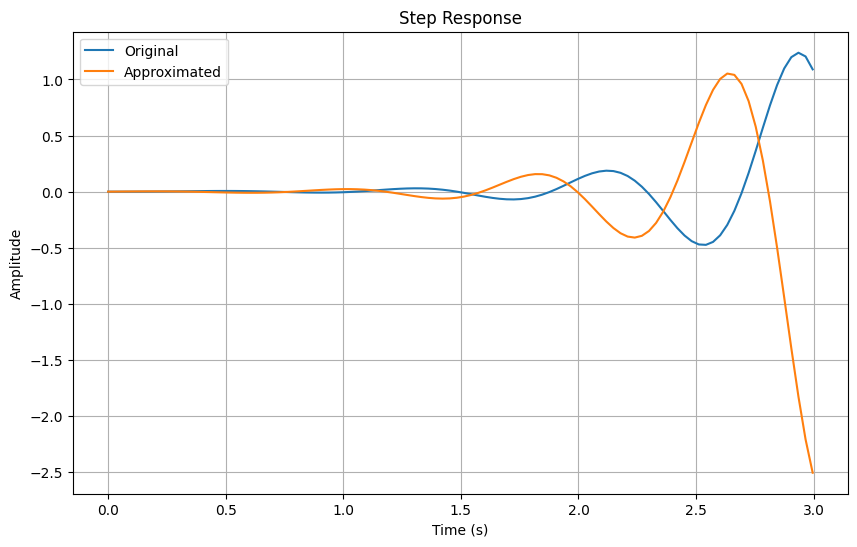

In [ ]:
import numpy as np
import sympy as sp
from scipy.signal import zpk2tf, residue, TransferFunction, bode, step, impulse
import ipywidgets as widgets
from IPython.display import display, clear_output, Math, Latex
import matplotlib.pyplot as plt

def parse_complex(s):
    """Parse a string into a complex number, handling 'i' as 'j'."""
    try:
        return complex(s.replace('i', 'j').replace(' ', ''))
    except:
        raise ValueError(f"Invalid complex number: {s}")

def dominant_pole_approximation(num, den, num_poles):
    """Perform dominant pole approximation by retaining specified number of poles."""
    # Find poles and zeros
    zeros = np.roots(num)
    poles = np.roots(den)

    # Sort poles by their real parts (smallest real part indicates dominant poles)
    poles_sorted = poles[np.argsort(np.abs(np.real(poles)))]
    dominant_poles = poles_sorted[:num_poles]

    # Reconstruct the approximated denominator polynomial
    den_approx = np.poly(dominant_poles)

    # For zeros, we'll keep all zeros for now (you might adjust this based on your approximation needs)
    num_approx = num.copy()

    # Adjust the gain to match the DC gain (or another frequency if desired)
    # Compute DC gain of original system
    w0 = 0  # DC frequency
    _, mag_orig, _ = bode(TransferFunction(num, den), [w0])
    _, mag_approx, _ = bode(TransferFunction(num_approx, den_approx), [w0])

    # Adjust the numerator to match the DC gain
    gain_adjustment = 10**((mag_orig[0] - mag_approx[0])/20)
    num_approx = gain_adjustment * num_approx

    return num_approx, den_approx

def display_transfer_function(num, den, zeros, poles, residues, poles_res, k_res, num_approx=None, den_approx=None, plot_type='Bode Plot', output_area=None):
    # """Display the transfer function in various forms and plot the selected response."""
    # with output_area:
        clear_output()  # Clear previous output in the output area
        display( num_coeffs_input, den_coeffs_input, num_poles_input, plot_type_widget, calc_button)
        s = sp.symbols('s', complex=True)

        # Original Transfer Function
        display(Latex(r'### Original Transfer Function'))
        # Rational Function Form
        num_poly = sp.Poly(num, s)
        den_poly = sp.Poly(den, s)
        H_s = num_poly.as_expr() / den_poly.as_expr()
        display(Latex('**Rational Function Form:**'))
        display(Math(r'H(s) = \frac{%s}{%s}' % (sp.latex(num_poly.as_expr()), sp.latex(den_poly.as_expr()))))

        # Factored Form
        zeros_expr = sp.Mul(*[s - z for z in zeros])
        poles_expr = sp.Mul(*[s - p for p in poles])
        gain = num[0] / den[0]
        display(Latex('**Factored Form:**'))
        display(Math(r'H(s) = %s \times \frac{%s}{%s}' % (sp.latex(gain), sp.latex(zeros_expr), sp.latex(poles_expr))))

        # Partial Fraction Expansion
        partial_frac_terms = [r'\frac{%s}{s - (%s)}' % (sp.latex(r), sp.latex(p)) for r, p in zip(residues, poles_res)]
        partial_frac = ' + '.join(partial_frac_terms)
        if k_res.size > 0:
            k_poly = sp.Poly(k_res, s)
            k_expr = sp.latex(k_poly.as_expr())
            partial_frac += ' + ' + k_expr
        # display(Latex('**Partial Fraction Expansion:**'))
        # display(Math('H(s) = %s' % partial_frac))

        display(Latex(r'**Partial Fraction Expansion:**'))
        display(Math(r'H(s) = %s' % partial_frac))


        # Plotting
        display(Latex(f'**{plot_type}:**'))
        # Create a TransferFunction object
        system = TransferFunction(num, den)

        if num_approx is not None and den_approx is not None:
            # Create TransferFunction object for approximated system
            system_approx = TransferFunction(num_approx, den_approx)

        if plot_type == 'Bode Plot':
            # Bode Plot
            w = np.logspace(-2, 2, 1000)
            w, mag, phase = bode(system, w=w)

            # Plotting
            fig, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize=(10, 8))

            # Magnitude plot
            ax_mag.semilogx(w, mag, label='Original')  # Bode magnitude plot
            ax_mag.set_title('Bode Plot')
            ax_mag.set_ylabel('Magnitude (dB)')
            ax_mag.grid(True, which='both', linestyle='--')

            # Phase plot
            ax_phase.semilogx(w, phase, label='Original')  # Bode phase plot
            ax_phase.set_xlabel('Frequency (rad/s)')
            ax_phase.set_ylabel('Phase (degrees)')
            ax_phase.grid(True, which='both', linestyle='--')

            if num_approx is not None and den_approx is not None:
                # Bode Plot of Approximated Function
                w_approx, mag_approx, phase_approx = bode(system_approx, w=w)

                # Plot the approximated magnitude and phase
                ax_mag.semilogx(w_approx, mag_approx, label='Approximated')
                ax_phase.semilogx(w_approx, phase_approx, label='Approximated')

                ax_mag.legend()
                ax_phase.legend()

            plt.tight_layout()
            plt.show()

        elif plot_type == 'Impulse Response':
            # Impulse Response
            t, y = impulse(system)
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(t, y, label='Original')
            ax.set_title('Impulse Response')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude')
            ax.grid(True)

            if num_approx is not None and den_approx is not None:
                t_approx, y_approx = impulse(system_approx, T=t)
                ax.plot(t_approx, y_approx, label='Approximated')

            ax.legend()
            plt.show()

        elif plot_type == 'Step Response':
            # Step Response
            t, y = step(system)
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(t, y, label='Original')
            ax.set_title('Step Response')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude')
            ax.grid(True)

            if num_approx is not None and den_approx is not None:
                t_approx, y_approx = step(system_approx, T=t)
                ax.plot(t_approx, y_approx, label='Approximated')

            ax.legend()
            plt.show()

def calculate_transfer_function(b):
    try:
        num_coeffs_list = [parse_complex(c) for c in num_coeffs_input.value.split(',') if c.strip()]
        den_coeffs_list = [parse_complex(c) for c in den_coeffs_input.value.split(',') if c.strip()]
        num_poles = num_poles_input.value
        plot_type = plot_type_widget.value
        
        num = np.array(num_coeffs_list, dtype=np.complex128)
        den = np.array(den_coeffs_list, dtype=np.complex128)
        
        zeros = np.roots(num)
        poles = np.roots(den)
        
        residues, poles_res, k_res = residue(num, den)
        
        # Perform dominant pole approximation
        num_approx, den_approx = dominant_pole_approximation(num, den, num_poles)
        
        display_transfer_function(num, den, zeros, poles, residues, poles_res, k_res, num_approx, den_approx, plot_type)
    except:
        pass



# Input widget for number of dominant poles
num_poles_input = widgets.BoundedIntText(
    value=1,
    min=1,
    max=10,
    step=1,
    description='Number of Dominant Poles:',
    disabled=False
)

# Plot type selection
plot_type_widget = widgets.Select(
    options=['Impulse Response', 'Step Response', 'Bode Plot'],
    value='Step Response',
    description='Response Comparison:',
    disabled=False
)
# Input widgets for numerator and denominator coefficients
num_coeffs_input = widgets.Text(description='Numerator Coeffs:', placeholder='Enter coeffs, comma-separated')
den_coeffs_input = widgets.Text(description='Denominator Coeffs:', placeholder='Enter coeffs, comma-separated')
calc_button = widgets.Button(description='Calculate Transfer Function')

display( num_coeffs_input, den_coeffs_input, num_poles_input, plot_type_widget, calc_button)
calc_button.on_click(calculate_transfer_function)


# PID Control

**PID control** or *Propotional-Integral-Derivative* control is a very common type of control used ina large variety of use cases. It is perhaps the most commonly used control algorithm. 


**What is a PID Controller?**

A PID controller is a control mechanism that uses a combination of three terms: **Proportional (P)**, **Integral (I)**, and **Derivative (D)** to calculate an output that will bring a system closer to a desired setpoint. The controller continuously calculates an error value as the difference between a desired setpoint and a measured process variable, and applies correction based on proportional, integral, and derivative terms.

Let's break down each component to understand how they contribute to the control action.

---

## The Components of PID Control

### 1. Proportional Control (P)

**Concept:** The proportional term produces an output value that is proportional to the current error value.

**Mathematical Representation:**

\[
\text{Output}_P = K_P \times e(t)
\]

- \( K_P \) is the proportional gain.
- \( e(t) \) is the error at time \( t \).

**Intuitive Explanation:**

Imagine you're steering a car to stay in the center of a lane. If you're drifting to the left, you need to steer to the right to correct your position. The further you are from the center, the more you need to turn the wheel. This immediate response to the error is akin to proportional control.

**Characteristics:**

- **Advantages:**
  - Simple and provides immediate corrective action.
- **Limitations:**
  - May not eliminate steady-state error (a constant offset from the desired setpoint).

---

### 2. Integral Control (I)

**Concept:** The integral term accounts for the accumulation of past errors. It integrates the error over time, providing a corrective action to eliminate residual steady-state errors.

**Mathematical Representation:**

\[
\text{Output}_I = K_I \times \int_{0}^{t} e(\tau) \, d\tau
\]

- \( K_I \) is the integral gain.

**Intuitive Explanation:**

Continuing with the car analogy, if you've been slightly off-center for a while, even if the error is small, over time it adds up. The integral term increases the corrective action the longer the error persists, pushing you back to the center.

**Characteristics:**

- **Advantages:**
  - Eliminates steady-state error.
- **Limitations:**
  - Can introduce overshoot and oscillations if not tuned properly.

---

### 3. Derivative Control (D)

**Concept:** The derivative term predicts future errors by calculating the rate of change of the error. It provides a damping action, reacting to how quickly the error is changing.

**Mathematical Representation:**

\[
\text{Output}_D = K_D \times \frac{de(t)}{dt}
\]

- \( K_D \) is the derivative gain.

**Intuitive Explanation:**

If you're correcting your car's position and you notice that the rate at which you're approaching the center is fast, you might ease off the steering to prevent overshooting. The derivative term helps anticipate future errors and adjusts the control action accordingly.

**Characteristics:**

- **Advantages:**
  - Improves system stability and response time.
- **Limitations:**
  - Sensitive to noise in the error signal.

---

## Combining the PID Terms

The PID controller combines all three terms to calculate the control output:

\[
\text{Control Output} = \text{Output}_P + \text{Output}_I + \text{Output}_D
\]

Or, in full:

\[
\text{Control Output} = K_P e(t) + K_I \int_{0}^{t} e(\tau) \, d\tau + K_D \frac{de(t)}{dt}
\]

Each term addresses different aspects of the system's performance:

- **Proportional:** Addresses present error.
- **Integral:** Addresses accumulated past error.
- **Derivative:** Predicts future error.

---

## How Does a PID Controller Work?

1. **Measurement:** The system measures the current process variable (e.g., temperature, speed).

2. **Error Calculation:** It computes the error \( e(t) \) by subtracting the process variable from the desired setpoint.

3. **Control Action Calculation:** The controller calculates the control output using the PID formula.

4. **Actuation:** The control output is applied to the system through an actuator (e.g., adjusting a valve, changing motor voltage).

5. **Feedback Loop:** Steps 1-4 repeat continuously, allowing the system to respond to changes and disturbances.

---


## Tuning PID Controllers

Selecting the appropriate gains \( K_P \), \( K_I \), and \( K_D \) is crucial for optimal performance.

- **Under-Tuned Controller:**
  - Slow response.
  - May not reach the setpoint efficiently.

- **Over-Tuned Controller:**
  - Can cause excessive overshoot.
  - May lead to oscillations or instability.

**Common Tuning Methods:**

- **Manual Tuning:**
  - Adjust gains based on observation.

- **Ziegler-Nichols Method:**
  - A systematic approach using specific rules.

- **Software Tools:**
  - Use algorithms to optimize gains, such as MATLABs Control System Designer.

---

## Practical Considerations

- **Sampling Time:** The controller should operate at a frequency that adequately captures system dynamics.

- **Noise Filtering:** Derivative control is sensitive to noise; filtering may be necessary.

- **Saturation and Windup:**
  - Actuators have limits (e.g., a heater can't produce infinite heat).
  - Integral windup occurs when the integral term accumulates excessively due to actuator saturation.
  - **Solution:** Implement integral windup prevention techniques.



Below is a tool that can be use to visualise how a PID controller changes the system. It also plots the root-locus plot of the closed loop system. So one can use this tool to find the requisite PID gains using the strategy as described in the lecture.

In [35]:
import numpy as np
import sympy as sp
from scipy.signal import TransferFunction
import control  # Import the control library
import ipywidgets as widgets
from IPython.display import display, clear_output, Math, Latex
import matplotlib.pyplot as plt

def parse_coefficients(s):
    """Parse a string of coefficients into a list of floats."""
    try:
        return [float(c) for c in s.replace(' ', '').split(',') if c.strip()]
    except:
        raise ValueError(f"Invalid coefficient: {s}")

def create_pid_controller(kp, ki, kd, s):
    """Create the transfer function of a PID controller."""
    pid = kp + ki / s + kd * s
    pid_num, pid_den = sp.fraction(pid)
    pid_num = sp.Poly(pid_num, s).all_coeffs()
    pid_den = sp.Poly(pid_den, s).all_coeffs()
    pid_num = [float(coef) for coef in pid_num]
    pid_den = [float(coef) for coef in pid_den]
    return pid_num, pid_den

def display_closed_loop_tf(plant_num, plant_den, controller_num, controller_den, output_area):
    """Compute and display the closed-loop transfer function and root locus plot."""
    with output_area:
        clear_output()  # Clear previous output in the output area
        s = sp.symbols('s')

        # Open-loop transfer function L(s) = G(s) * C(s)
        open_loop_num = np.polymul(plant_num, controller_num)
        open_loop_den = np.polymul(plant_den, controller_den)

        # Closed-loop transfer function T(s) = L(s) / (1 + L(s))
        # Numerator: N(s) = G(s) * C(s)
        # Denominator: D(s) = G(s) * C(s) + 1
        # Compute the closed-loop numerator and denominator
        closed_loop_num = open_loop_num
        closed_loop_den = np.polyadd(open_loop_den, open_loop_num)  # Denominator is OL_den + OL_num

        # Display the closed-loop transfer function
        num_poly = sp.Poly(closed_loop_num, s)
        den_poly = sp.Poly(closed_loop_den, s)
        display(Latex('**Closed-Loop Transfer Function T(s):**'))
        display(Math(r'T(s) = \frac{%s}{%s}' % (sp.latex(num_poly.as_expr()), sp.latex(den_poly.as_expr()))))

        # Find and display the poles of the closed-loop system
        poles = np.roots(closed_loop_den)
        display(Latex('**Poles of the Closed-Loop System:**'))
        for idx, pole in enumerate(poles, 1):
            display(Math(r'p_%d = %s' % (idx, sp.latex(pole))))
        
        # Root Locus Plot
        display(Latex('**Root Locus Plot:**'))
        # Create TransferFunction objects for root locus using the control library
        sys_open_loop = control.TransferFunction(open_loop_num, open_loop_den)
        
        # Plot root locus
        fig, ax = plt.subplots(figsize=(8, 6))
        control.root_locus(sys_open_loop, ax=ax)
        ax.set_title('Root Locus Plot')
        ax.set_xlabel('Real Axis')
        ax.set_ylabel('Imaginary Axis')
        ax.grid(True, which='both')
        plt.show()

def on_calculate_button_click(b):
    try:
        # Parse the plant transfer function coefficients
        plant_num_coeffs = parse_coefficients(plant_num_input.value)
        plant_den_coeffs = parse_coefficients(plant_den_input.value)
        plant_num = np.array(plant_num_coeffs, dtype=float)
        plant_den = np.array(plant_den_coeffs, dtype=float)
        
        # Create symbolic variable s
        s = sp.symbols('s')
        
        # Initialize controller gains
        kp = float(kp_input.value) if kp_checkbox.value else 0
        ki = float(ki_input.value) if ki_checkbox.value else 0
        kd = float(kd_input.value) if kd_checkbox.value else 0
        
        # Check if at least one controller gain is non-zero
        if kp == 0 and ki == 0 and kd == 0:
            raise ValueError("At least one controller gain must be non-zero.")
        
        # Create the PID controller transfer function
        controller_num, controller_den = create_pid_controller(kp, ki, kd, s)
        
        # Display results
        display_closed_loop_tf(plant_num, plant_den, controller_num, controller_den, output_area)
        
    except Exception as e:
        with output_area:
            clear_output()
            display(Latex(f'Error: {e}'))

# Input widgets
plant_num_input = widgets.Text(
    description='Plant Numerator:',
    placeholder='Enter coeffs, highest power first'
)
plant_den_input = widgets.Text(
    description='Plant Denominator:',
    placeholder='Enter coeffs, highest power first'
)

# Controller selection checkboxes
kp_checkbox = widgets.Checkbox(
    value=True,
    description='Proportional (Kp)',
    disabled=False
)
ki_checkbox = widgets.Checkbox(
    value=False,
    description='Integral (Ki)',
    disabled=False
)
kd_checkbox = widgets.Checkbox(
    value=False,
    description='Derivative (Kd)',
    disabled=False
)

# Controller gain inputs
kp_input = widgets.Text(
    description='Kp:',
    value='1',
    placeholder='Enter Kp value'
)
ki_input = widgets.Text(
    description='Ki:',
    value='0',
    placeholder='Enter Ki value'
)
kd_input = widgets.Text(
    description='Kd:',
    value='0',
    placeholder='Enter Kd value'
)

# Button to calculate
calculate_button = widgets.Button(
    description='Calculate',
    button_style='success'
)

# Output area
output_area = widgets.Output()

# Event handler for calculate button
calculate_button.on_click(on_calculate_button_click)

# Display the widgets
display(plant_num_input, plant_den_input)
display(Latex('**Select Controller Terms:**'))
display(kp_checkbox, kp_input)
display(ki_checkbox, ki_input)
display(kd_checkbox, kd_input)
display(calculate_button)
display(output_area)


Text(value='', description='Plant Numerator:', placeholder='Enter coeffs, highest power first')

Text(value='', description='Plant Denominator:', placeholder='Enter coeffs, highest power first')

<IPython.core.display.Latex object>

Checkbox(value=True, description='Proportional (Kp)')

Text(value='1', description='Kp:', placeholder='Enter Kp value')

Checkbox(value=False, description='Integral (Ki)')

Text(value='0', description='Ki:', placeholder='Enter Ki value')

Checkbox(value=False, description='Derivative (Kd)')

Text(value='0', description='Kd:', placeholder='Enter Kd value')

Button(button_style='success', description='Calculate', style=ButtonStyle())

Output()

## PS07 Problems

The tool below has been modified to be used for Problem 3, 4 from the problem set.

Text(value='8.5', description='Plant ωₙ:')

Text(value='0.36', description='Plant ζ:')

<IPython.core.display.Latex object>

Checkbox(value=True, description='Proportional (Kp)')

Text(value='1', description='Kp:', placeholder='Enter Kp value')

Checkbox(value=False, description='Integral (Ki)')

Text(value='0', description='Ki:', placeholder='Enter Ki value')

Checkbox(value=False, description='Derivative (Kd)')

Text(value='0', description='Kd:', placeholder='Enter Kd value')

Button(button_style='success', description='Calculate', style=ButtonStyle())

Output()

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

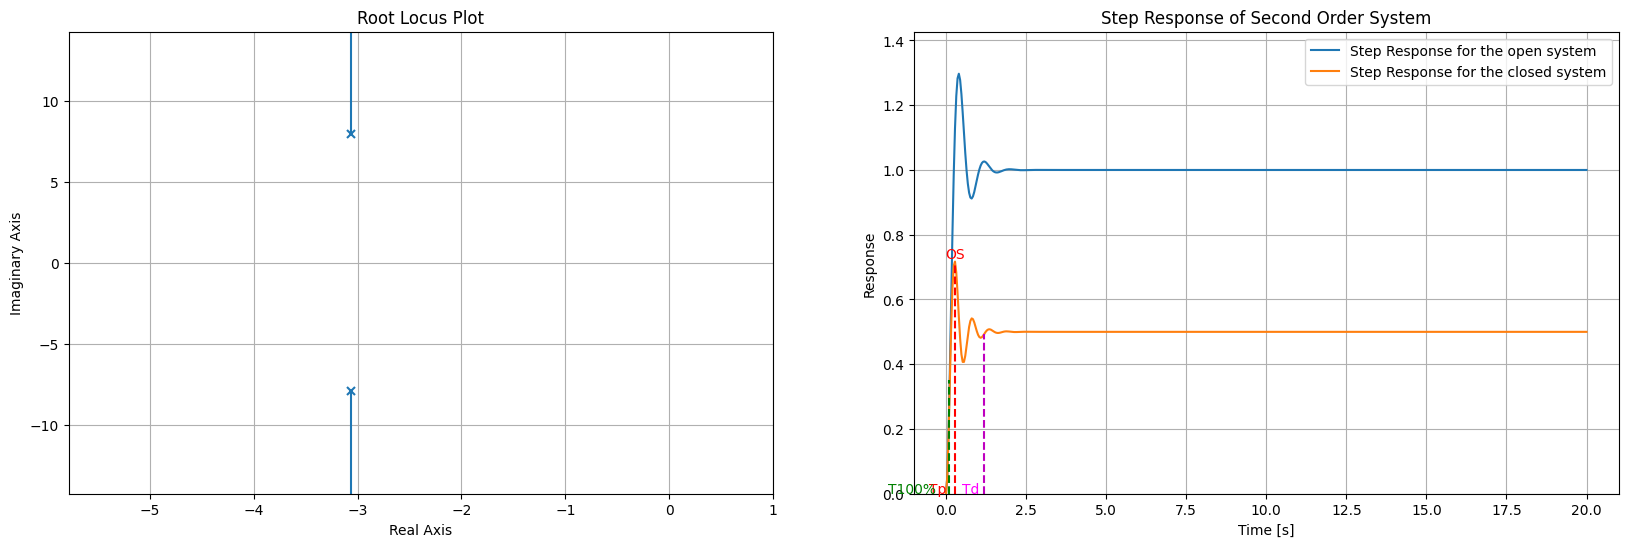

In [ ]:
import numpy as np
import sympy as sp
from scipy.signal import TransferFunction
import control  # Import the control library
import ipywidgets as widgets
from IPython.display import display, clear_output, Math, Latex
import matplotlib.pyplot as plt

# def parse_coefficients(s):
#     """Parse a string of coefficients into a list of floats."""
#     try:
#         return [float(c) for c in s.replace(' ', '').split(',') if c.strip()]
#     except:
#         raise ValueError(f"Invalid coefficient: {s}")

def create_pid_controller(kp, ki, kd, s):
    """Create the transfer function of a PID controller."""
    pid = kp + ki / s + kd * s
    pid_num, pid_den = sp.fraction(pid)
    pid_num = sp.Poly(pid_num, s).all_coeffs()
    pid_den = sp.Poly(pid_den, s).all_coeffs()
    pid_num = [float(coef) for coef in pid_num]
    pid_den = [float(coef) for coef in pid_den]
    return pid_num, pid_den

def display_closed_loop_tf(plant_num, plant_den, controller_num, controller_den, output_area):
        """Compute and display the closed-loop transfer function and root locus plot."""
    # with output_area:
        clear_output()  # Clear previous output in the output area
        display(plant_omega_input, plant_zeta_input)
        display(Latex('**Select Controller Terms:**'))
        display(kp_checkbox, kp_input)
        display(ki_checkbox, ki_input)
        display(kd_checkbox, kd_input)
        display(calculate_button)
        display(output_area)


        s = sp.symbols('s')

        # Open-loop transfer function L(s) = G(s) * C(s)
        open_loop_num = np.polymul(plant_num, controller_num)
        open_loop_den = np.polymul(plant_den, controller_den)

        # Closed-loop transfer function T(s) = L(s) / (1 + L(s))
        # Numerator: N(s) = G(s) * C(s)
        # Denominator: D(s) = G(s) * C(s) + 1
        # Compute the closed-loop numerator and denominator
        closed_loop_num = open_loop_num
        closed_loop_den = np.polyadd(open_loop_den, open_loop_num)  # Denominator is OL_den + OL_num

        # Display the closed-loop transfer function
        num_poly = sp.Poly(closed_loop_num, s)
        den_poly = sp.Poly(closed_loop_den, s)
        display(Latex('**Closed-Loop Transfer Function T(s):**'))
        display(Math(r'T(s) = \frac{%s}{%s}' % (sp.latex(num_poly.as_expr()), sp.latex(den_poly.as_expr()))))

        # Find and display the poles of the closed-loop system
        poles = np.roots(closed_loop_den)
        display(Latex('**Poles of the Closed-Loop System:**'))
        for idx, pole in enumerate(poles, 1):
            display(Math(r'p_%d = %s' % (idx, sp.latex(pole))))
        
        # Root Locus Plot
        display(Latex('**Root Locus Plot:**'))
        # Create TransferFunction objects for root locus using the control library
        sys_open_loop = control.TransferFunction(open_loop_num, open_loop_den)
        


        t, response_open, response_closed, S_open, S_closed = step_response(plant_num, plant_den, controller_num, controller_den)


        # Plot root locus
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
        control.root_locus(sys_open_loop, ax=ax1)
        ax1.set_title('Root Locus Plot')
        ax1.set_xlabel('Real Axis')
        ax1.set_ylabel('Imaginary Axis')
        ax1.grid(True, which='both')
        

        ax2.plot(t, response_open, label='Step Response for the open system')
        # plt.hold()
        ax2.plot(t, response_closed, label='Step Response for the closed system')

        ax2.set_title('Step Response of Second Order System')
        ax2.set_xlabel('Time [s]')
        ax2.set_ylabel('Response')
        ax2.legend()
        ax2.grid(True)
    # plt.grid(True)
        ax2.set_ylim(0, 1.1 * max(response_open.max(), response_closed.max()))

        Tp = S_closed['PeakTime']
        Tr = S_closed['RiseTime']
        Ts = S_closed['SettlingTime']
        # tau = S_closed['SettlingTime']
        


        # if show_time_to_peak and not np.isnan(Tp):
        ax2.text(Tp, 0, f'Tp  ', color='red', fontsize=10, ha='right')
        ax2.plot([Tp, Tp], [0, response_closed[np.where(t >= Tp)[0][0]]], color='r', linestyle='--')


        ax2.text(Tp, response_closed.max(), f'OS', color='red', fontsize=10, ha='center', va='bottom')

    # if show_rise_time and not np.isnan(Tr):
        ax2.text(Tr,0, f'T100%   ', color='green', fontsize=10, ha='right')
        ax2.plot([Tr, Tr], [0, response_closed[np.where(t >= Tr)[0][0]]], color='g', linestyle='--')

    # if show_settling_time and not np.isnan(Ts):
        ax2.text(Ts, 0, f'Td ', color='magenta', fontsize=10, ha='right')
        ax2.plot([Ts, Ts], [0, response_closed[np.where(t >= Ts)[0][0]]], color='m', linestyle='--')

    # # if show_time_constant and not np.isnan(tau):
    #     ax2.text(tau, 0, f'τ ', color='cyan', fontsize=10, ha='right')
    #     ax2.plot([tau, tau], [0, response_closed[np.where(t >= tau)[0][0]]], color='c', linestyle='--')



        plt.show()



def step_response(plant_num, plant_den, controller_num, controller_den):

    # Open-loop transfer function L(s) = G(s) * C(s)
    open_loop_num = plant_num
    open_loop_den = plant_den

    # Closed-loop transfer function T(s) = L(s) / (1 + L(s))
    # Numerator: N(s) = G(s) * C(s)
    # Denominator: D(s) = G(s) * C(s) + 1
    # Compute the closed-loop numerator and denominator
    closed_loop_num = np.polymul(plant_num, controller_num)
    closed_loop_den = np.polyadd(np.polymul(plant_den, controller_den), np.polymul(plant_num, controller_num))  # Denominator is OL_den + OL_num

    system_open = control.TransferFunction(open_loop_num, open_loop_den)
    system_closed = control.TransferFunction(closed_loop_num, closed_loop_den)
    

    
    t = np.linspace(0, 20, 500)
    t, response_open = control.step_response(system_open, T=t)
    t, response_closed = control.step_response(system_closed, T=t)

    S_open = control.step_info(system_open)
    S_closed = control.step_info(system_closed)


    return t, response_open, response_closed, S_open, S_closed


def on_calculate_button_click(b):
    try:
        # Parse the plant transfer function coefficients
        try:
            plant_omega = float(plant_omega_input.value)
            plant_zeta = float(plant_zeta_input.value)
        except:
            raise ValueError('Invalid plant coefficients')
        
        plant_num = np.array([plant_omega**2], dtype=float)
        plant_den = np.array([1, 2*plant_omega*plant_zeta, plant_omega**2], dtype=float)
        
        # Create symbolic variable s
        s = sp.symbols('s')
        
        # Initialize controller gains
        kp = float(kp_input.value) if kp_checkbox.value else 0
        ki = float(ki_input.value) if ki_checkbox.value else 0
        kd = float(kd_input.value) if kd_checkbox.value else 0
        
        # # Check if at least one controller gain is non-zero
        # if kp == 0 and ki == 0 and kd == 0:
        #     raise ValueError("At least one controller gain must be non-zero.")
        
        # Create the PID controller transfer function
        controller_num, controller_den = create_pid_controller(kp, ki, kd, s)
        
        # Display results
        display_closed_loop_tf(plant_num, plant_den, controller_num, controller_den, output_area)
        
    except Exception as e:
        with output_area:
            clear_output()
            display(Latex(f'Error: {e}'))

# Input widgets
plant_zeta_input = widgets.Text(
    description='Plant ζ:',
    
    # placeholder
)
plant_omega_input = widgets.Text(
    description='Plant ωₙ:',
    # placeholder='Enter coeffs, highest power first'
)


# Controller selection checkboxes
kp_checkbox = widgets.Checkbox(
    value=True,
    description='Proportional (Kp)',
    disabled=False
)
ki_checkbox = widgets.Checkbox(
    value=False,
    description='Integral (Ki)',
    disabled=False
)
kd_checkbox = widgets.Checkbox(
    value=False,
    description='Derivative (Kd)',
    disabled=False
)

# Controller gain inputs
kp_input = widgets.Text(
    description='Kp:',
    value='1',
    placeholder='Enter Kp value'
)
ki_input = widgets.Text(
    description='Ki:',
    value='0',
    placeholder='Enter Ki value'
)
kd_input = widgets.Text(
    description='Kd:',
    value='0',
    placeholder='Enter Kd value'
)

# Button to calculate
calculate_button = widgets.Button(
    description='Calculate',
    button_style='success'
)

# Output area
output_area = widgets.Output()

# Event handler for calculate button
calculate_button.on_click(on_calculate_button_click)

# Display the widgets
display(plant_omega_input, plant_zeta_input)
display(Latex('**Select Controller Terms:**'))
display(kp_checkbox, kp_input)
display(ki_checkbox, ki_input)
display(kd_checkbox, kd_input)
display(calculate_button)
display(output_area)
